## Execution of different models against the tabfact dataset:

https://github.com/huggingface/transformers/tree/main/examples/research_projects/tapex

Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score
from matplotlib import rcParams
from tqdm.notebook import tqdm


### Choose Execution Style:

In [2]:
RUN_SCRIPT = True # Set to True to run the script, False to use the adjusted scripts for executing the code in the notebook

In [3]:
this_dir = os.getcwd()
base_path = os.path.join('original_repo', 'code')

if RUN_SCRIPT:
    os.chdir(base_path)
else:
    current_dir = os.getcwd()
    target_dir = os.path.join(current_dir, base_path)
    os.chdir(target_dir)

print("Current working directory:", os.getcwd())

Current working directory: /Users/luka512/Desktop/GitHubProjects/table-fact-checking/original_repo/code


### Plotting functionality:

In [4]:
def plot_confusion_matrix(
    all_labels, 
    pred_labels, 
    title="Confusion Matrix", 
    figsize=(6, 5), 
    font="Times New Roman", 
    save_path=None
):
    """
    Plots a confusion matrix using Seaborn heatmap.

    Parameters:
    -----------
    all_labels : list or array
        True labels (0/1).
    pred_labels : list or array
        Predicted labels (0/1).
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    font : str
        Font family to use.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    cm = confusion_matrix(all_labels, pred_labels)
    
    # Set font globally
    rcParams['font.family'] = font
    
    plt.figure(figsize=figsize)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', cbar=False,
        xticklabels=['Pred 0', 'Pred 1'],
        yticklabels=['True 0', 'True 1']
    )
    plt.title(title, fontsize=14, weight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()

def plot_roc_curve(
    all_labels, 
    all_probs, 
    title="Receiver Operating Characteristic", 
    figsize=(6, 5), 
    font="Times New Roman", 
    save_path=None
):
    """
    Plots the ROC curve with AUC value.

    Parameters:
    -----------
    all_labels : list or array
        True labels (0/1).
    all_probs : list or array
        Predicted probabilities for the positive class.
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    font : str
        Font family to use.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    # Set font globally
    rcParams['font.family'] = font
    
    plt.figure(figsize=figsize)
    plt.plot(
        fpr, tpr, color='darkorange', lw=2,
        label=f'ROC curve (AUC = {roc_auc:.2f})'
    )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()

def plot_multi_roc_curves(
    models_data, 
    title="ROC Comparison", 
    figsize=(6, 5), 
    font="Times New Roman", 
    save_path=None
):
    """
    Plots ROC curves for multiple models on the same plot.

    Parameters:
    -----------
    models_data : list of dicts
        Each dict must have:
            {
              "name": "Model name (str)",
              "labels": list of true labels (0/1),
              "probs": list of predicted probabilities for label=1
            }
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    font : str
        Font family to use.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    rcParams['font.family'] = font
    plt.figure(figsize=figsize)

    for model_info in models_data:
        name = model_info["name"]
        labels = model_info["labels"]
        probs = model_info["probs"]

        fpr, tpr, _ = roc_curve(labels, probs)
        roc_auc = auc(fpr, tpr)

        plt.plot(
            fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})'
        )

    # Plot the diagonal
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()

def plot_precision_recall_curve(
    all_labels, 
    all_probs, 
    title="Precision-Recall Curve", 
    figsize=(6, 5), 
    font="Times New Roman", 
    save_path=None
):
    """
    Plots the Precision-Recall curve with Average Precision (AP) score.

    Parameters:
    -----------
    all_labels : list or array
        True labels (0/1).
    all_probs : list or array
        Predicted probabilities for the positive class.
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    font : str
        Font family to use.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
    avg_precision = average_precision_score(all_labels, all_probs)
    
    # Set font globally
    rcParams['font.family'] = font
    
    plt.figure(figsize=figsize)
    plt.plot(
        recall, precision, color='darkorange', lw=2, 
        label=f'AP = {avg_precision:.2f}'
    )
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.legend(loc="lower left", fontsize=10)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()


def plot_multi_pr_curves(
    models_data, 
    title="Precision-Recall Comparison", 
    figsize=(6, 5), 
    font="Times New Roman", 
    save_path=None
):
    """
    Plots Precision-Recall curves for multiple models on the same plot.

    Parameters:
    -----------
    models_data : list of dicts
        Each dict must have:
            {
              "name": "Model name (str)",
              "labels": list of true labels (0/1),
              "probs": list of predicted probabilities for label=1
            }
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    font : str
        Font family to use.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    rcParams['font.family'] = font
    plt.figure(figsize=figsize)

    for model_info in models_data:
        name = model_info["name"]
        labels = model_info["labels"]
        probs = model_info["probs"]

        precision, recall, _ = precision_recall_curve(labels, probs)
        avg_precision = average_precision_score(labels, probs)

        plt.plot(
            recall, precision, lw=2,
            label=f'{name} (AP = {avg_precision:.2f})'
        )

    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.legend(loc="lower left", fontsize=10)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()

def plot_probability_distribution(
    all_probs, 
    title="Probability Distribution", 
    figsize=(6, 5), 
    font="Times New Roman", 
    save_path=None
):
    """
    Plots the distribution of predicted probabilities.

    Parameters:
    -----------
    all_probs : list or array
        Predicted probabilities for the positive class.
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    font : str
        Font family to use.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    # Set font globally
    rcParams['font.family'] = font
    
    plt.figure(figsize=figsize)
    plt.hist(
        all_probs, bins=20, color='darkorange', 
        edgecolor='black', alpha=0.7
    )
    plt.xlabel('Predicted Probability', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()

def plot_multi_probability_distributions(
    models_data, 
    title="Probability Distributions", 
    figsize=(6, 5), 
    font="Times New Roman", 
    save_path=None
):
    """
    Overlaid histogram of predicted probabilities for multiple models.

    Parameters:
    -----------
    models_data : list of dicts
        Each dict must have:
            {
              "name": "Model name (str)",
              "probs": list of predicted probabilities
            }
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    font : str
        Font family to use.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    rcParams['font.family'] = font
    plt.figure(figsize=figsize)

    bins = np.linspace(0, 1, 20)
    for model_info in models_data:
        name = model_info["name"]
        probs = model_info["probs"]
        plt.hist(
            probs, bins=bins, alpha=0.5, 
            edgecolor='black', label=name
        )

    plt.xlabel('Predicted Probability', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.legend(fontsize=10)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()


def plot_multi_probability_distributions_percent(
    models_data, 
    title="Probability Distributions (Percent)", 
    figsize=(6, 5), 
    font="Times New Roman", 
    save_path=None
):
    """
    Overlaid histogram of predicted probabilities in percentage terms for multiple models.

    Parameters:
    -----------
    models_data : list of dicts
        Each dict must have:
            {
              "name": "Model name (str)",
              "probs": list of predicted probabilities
            }
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    font : str
        Font family to use.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    rcParams['font.family'] = font
    plt.figure(figsize=figsize)

    bins = np.linspace(0, 1, 20)
    for model_info in models_data:
        name = model_info["name"]
        probs = model_info["probs"]
        # Calculate weights to represent percentages
        weights = np.ones_like(probs) * 100.0 / len(probs)
        plt.hist(
            probs, bins=bins, alpha=0.5, 
            edgecolor='black', label=name, weights=weights
        )

    plt.xlabel('Predicted Probability', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.legend(fontsize=10)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()

def plot_threshold_metrics(
    all_labels, 
    all_probs, 
    thresholds=None, 
    font="Times New Roman", 
    title="Threshold vs Metrics", 
    figsize=(8, 6), 
    save_path=None
):
    """
    Plots precision, recall, and F1-score as functions of the decision threshold.

    Parameters:
    -----------
    all_labels : list or array
        True labels (0/1).
    all_probs : list or array
        Predicted probabilities for the positive class.
    thresholds : list or array, optional
        Threshold values to evaluate. Defaults to np.linspace(0, 1, 100).
    font : str
        Font family to use.
    title : str
        Title of the plot.
    figsize : tuple
        Size of the figure in inches.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    if thresholds is None:
        thresholds = np.linspace(0, 1, 100)
        
    precisions = []
    recalls = []
    f1_scores = []

    for thresh in tqdm(thresholds, desc="Calculating metrics for thresholds"):
        preds = [1 if p > thresh else 0 for p in all_probs]
        # Handle cases where there might be no positive predictions
        try:
            precisions.append(precision_score(all_labels, preds))
        except:
            precisions.append(0)
        try:
            recalls.append(recall_score(all_labels, preds))
        except:
            recalls.append(0)
        try:
            f1_scores.append(f1_score(all_labels, preds))
        except:
            f1_scores.append(0)
    
    # Set font globally
    rcParams['font.family'] = font
    
    plt.figure(figsize=figsize)
    plt.plot(thresholds, precisions, label='Precision', lw=2)
    plt.plot(thresholds, recalls, label='Recall', lw=2)
    plt.plot(thresholds, f1_scores, label='F1-Score', lw=2)
    plt.xlabel('Threshold', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.legend(loc="best", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()


def plot_multi_threshold_metrics(
    models_data, 
    thresholds=None, 
    title="Threshold vs Metrics", 
    font="Times New Roman", 
    figsize=(10, 8), 
    save_path=None
):
    """
    Plots precision, recall, and F1-score vs threshold for each model in the same figure.

    Parameters:
    -----------
    models_data : list of dicts
        Each dict must have:
            {
              "name": "Model name (str)",
              "labels": list of true labels (0/1),
              "probs": list of predicted probabilities for label=1
            }
    thresholds : list or array, optional
        Threshold values to evaluate. Defaults to np.linspace(0, 1, 100).
    title : str
        Title of the plot.
    font : str
        Font family to use.
    figsize : tuple
        Size of the figure in inches.
    save_path : str or None
        If provided, saves the plot to this path as a PDF.
    """
    if thresholds is None:
        thresholds = np.linspace(0, 1, 100)

    rcParams['font.family'] = font
    plt.figure(figsize=figsize)

    for model_info in models_data:
        name = model_info["name"]
        labels = model_info["labels"]
        probs = model_info["probs"]

        precisions = []
        recalls = []
        f1_scores = []

        for thresh in thresholds:
            preds = [1 if p > thresh else 0 for p in probs]
            # Handle cases where there might be no positive predictions
            try:
                precisions.append(precision_score(labels, preds))
            except:
                precisions.append(0)
            try:
                recalls.append(recall_score(labels, preds))
            except:
                recalls.append(0)
            try:
                f1_scores.append(f1_score(labels, preds))
            except:
                f1_scores.append(0)

        plt.plot(
            thresholds, f1_scores, label=f'{name} F1-Score', lw=2
        )
        plt.plot(
            thresholds, precisions, label=f'{name} Precision', lw=1, linestyle='--'
        )
        plt.plot(
            thresholds, recalls, label=f'{name} Recall', lw=1, linestyle=':'
        )

    plt.xlabel('Threshold', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title(title, fontsize=16, weight='bold')
    plt.legend(loc="best", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()

### Execution of the lpa model

In [5]:
# !sh get_data.sh # to be run only once in the beginning

In [6]:
if RUN_SCRIPT:
    !python model.py --do_test --resume

Loading used 2.116252899169922 secs
Reloading saved model from checkpoints/
TP: 40205, FP: 22854, FN: 36443, TN: 33816. precision = 0.6375774966685566: recall = 0.5245407509062108
success = 8314, fail = 4465, accuracy = 0.650598587479569
Precision = 0.6375774966685566
Recall = 0.5245407509062108
Accuracy = 0.650598587479569


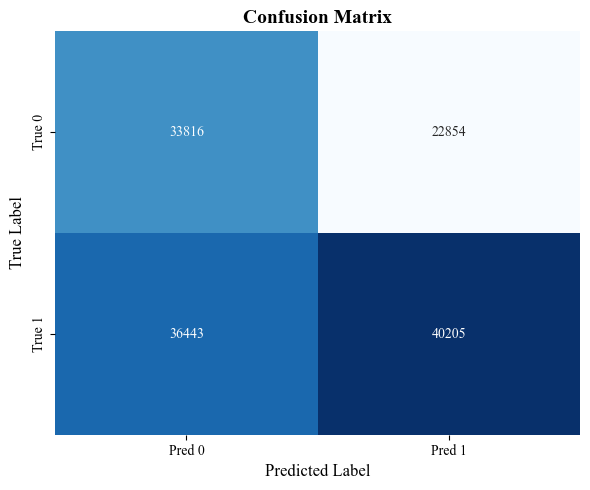

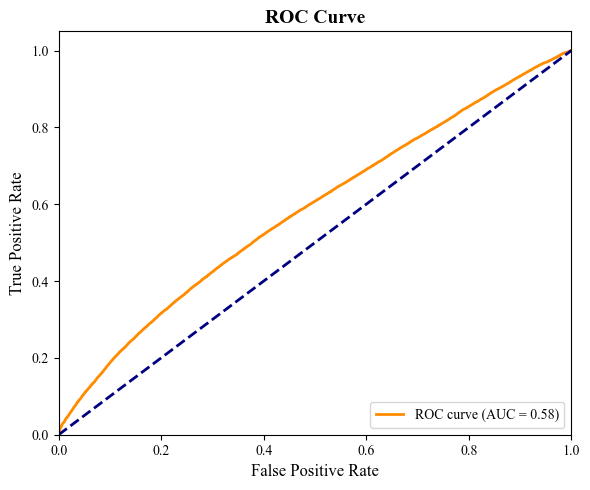

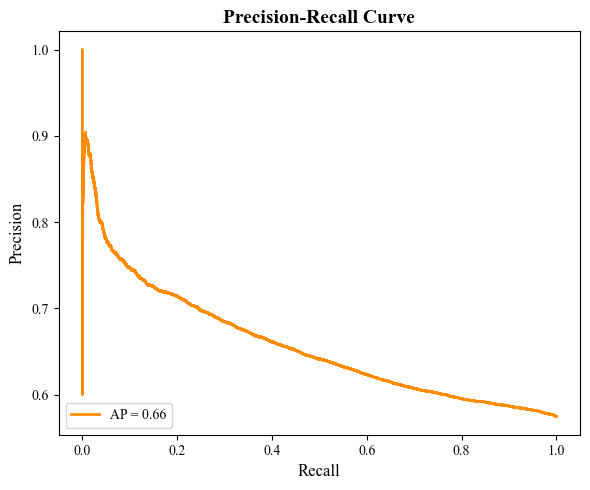

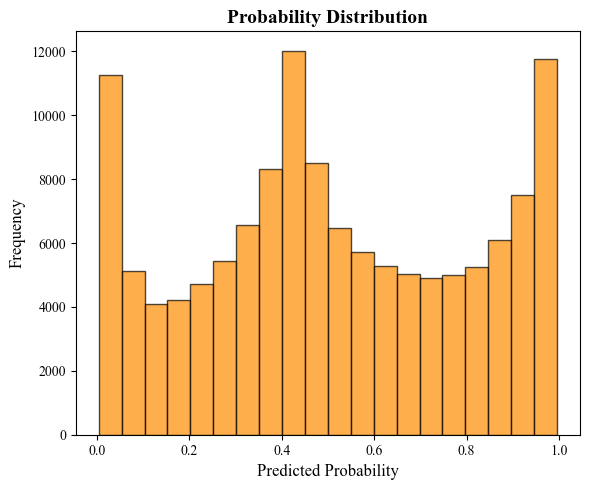

Calculating metrics for thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/miniconda3/envs/inf554/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


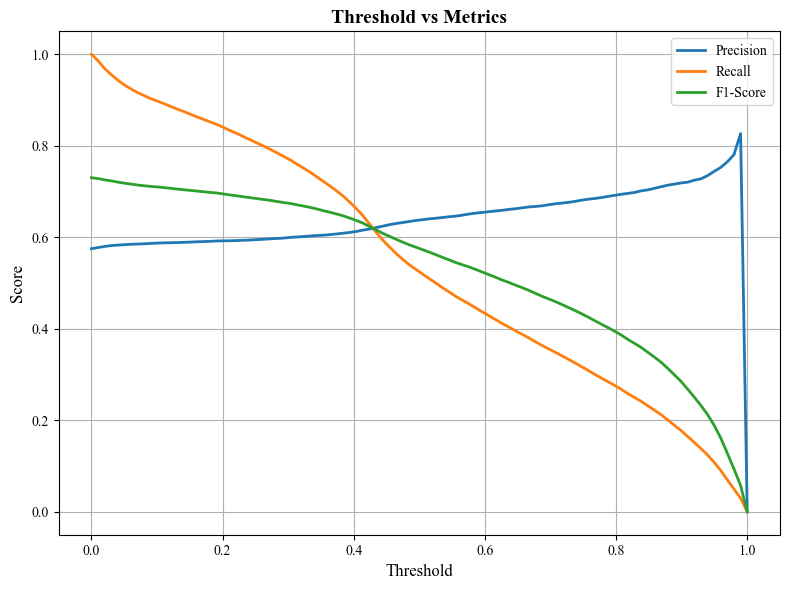

In [7]:
if not RUN_SCRIPT:
    import model_adjusted as lpa_model

    args = {
        'do_train': False,
        'do_val': False,
        'do_test': True,
        'do_simple_test': False,
        'do_complex_test': False,
        'do_small_test': False,
        'emb_dim': 128,
        'dropout': 0.2,
        'resume': True,
        'batch_size': 512,
        'data_dir': '../preprocessed_data_program/',
        'max_seq_length': 100,
        'layer_num': 3,
        'voting': False,
        'id': "0",
        'analyze': False,
        'threshold': 0.5,
        'output_dir': 'checkpoints/',
        'learning_rate': 5e-4
    }


    lpa_results = lpa_model.run_experiment(args)

    if lpa_results is not None:
        lpa_precision = lpa_results['precision']
        lpa_recall = lpa_results['recall']
        lpa_accuracy = lpa_results['accuracy']
        lpa_all_labels = lpa_results['labels']
        lpa_all_probs = lpa_results['probs']

        print("Precision =", lpa_precision)
        print("Recall =", lpa_recall)
        print("Accuracy =", lpa_accuracy)

        # PLOTTING
        # Convert probabilities to binary predictions
        lpa_pred_labels = [1 if p > args['threshold'] else 0 for p in lpa_all_probs]
        
        save_path = os.path.join(this_dir, 'plots', 'lpa')
        plot_confusion_matrix(lpa_all_labels, lpa_pred_labels, title="Confusion Matrix", save_path=os.path.join(save_path, "confusion_matrix.pdf"))
        plot_roc_curve(lpa_all_labels, lpa_all_probs, title="ROC Curve", save_path=os.path.join(save_path, "roc_curve.pdf"))
        plot_precision_recall_curve(lpa_all_labels, lpa_all_probs, title="Precision-Recall Curve", save_path=os.path.join(save_path, "precision_recall_curve.pdf"))
        plot_probability_distribution(lpa_all_probs, title="Probability Distribution", save_path=os.path.join(save_path, "probability_distribution.pdf"))
        plot_threshold_metrics(lpa_all_labels, lpa_all_probs, title="Threshold vs Metrics", save_path=os.path.join(save_path, "threshold_metrics.pdf"))

### Execution of Table-BERT model

Download checkpoint

(to be executed once in the beginning)

In [8]:
# !wget https://tablefact.s3-us-west-2.amazonaws.com/snapshot.zip
# !unzip snapshot.zip

In [9]:
if RUN_SCRIPT:
    !python run_BERT.py --do_eval --scan horizontal --fact first --load_dir outputs_fact-first_horizontal_snapshot/save_step_12500 --eval_batch_size 16

12/27/2024 14:46:15 - INFO - run_BERT_adjusted -   Running BERT with provided dictionary arguments:
12/27/2024 14:46:15 - INFO - run_BERT_adjusted -   Device: mps, n_gpu: 1
12/27/2024 14:46:15 - INFO - run_BERT_adjusted -   Datasets are loaded from ../processed_datasets/tsv_data_horizontal
Outputs will be saved to outputs_fact-first_horizontal


{'do_eval': True,
 'do_train': False,
 'eval_batch_size': 16,
 'fact': 'first',
 'load_dir': 'outputs_fact-first_horizontal_snapshot/save_step_12500',
 'scan': 'horizontal',
 'threshold': 0.5}


12/27/2024 14:46:29 - INFO - run_BERT_adjusted -   ***** Running evaluation *****
12/27/2024 14:46:29 - INFO - run_BERT_adjusted -     Num examples = 12791
12/27/2024 14:46:29 - INFO - run_BERT_adjusted -     Batch size = 16
Evaluating: 100%|██████████| 800/800 [06:24<00:00,  2.08it/s]


Evaluation results: {'acc': 0.6574935501524509, 'f1': 0.6933575978161965, 'acc_and_f1': 0.6754255739843238, 'eval_loss': 0.589219210576266}


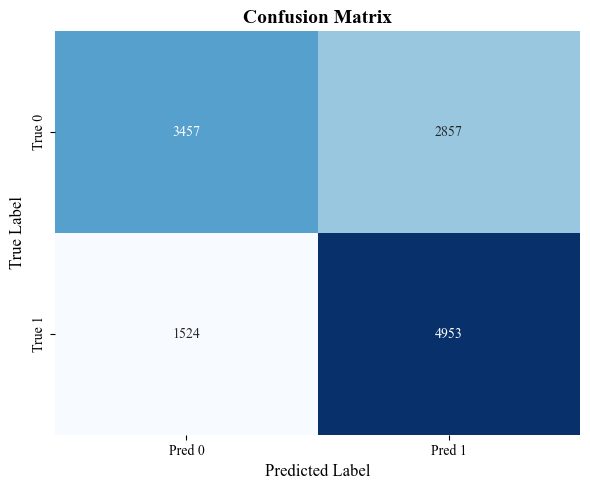

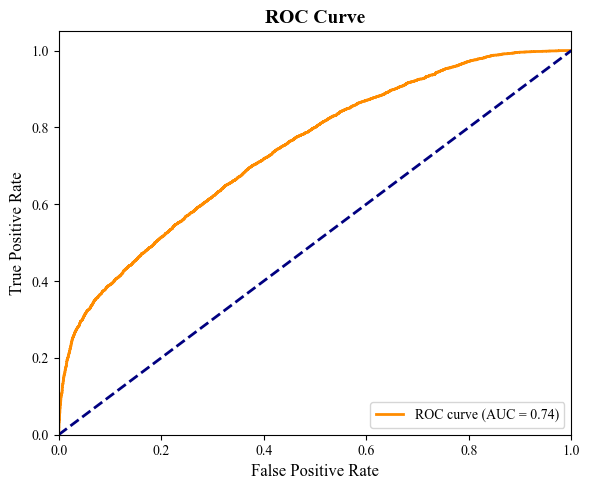

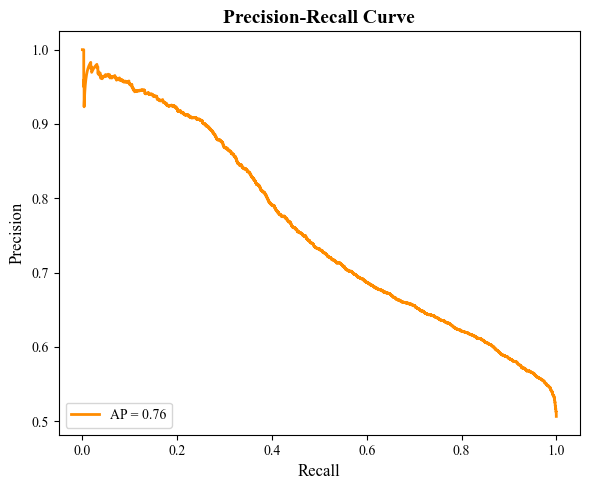

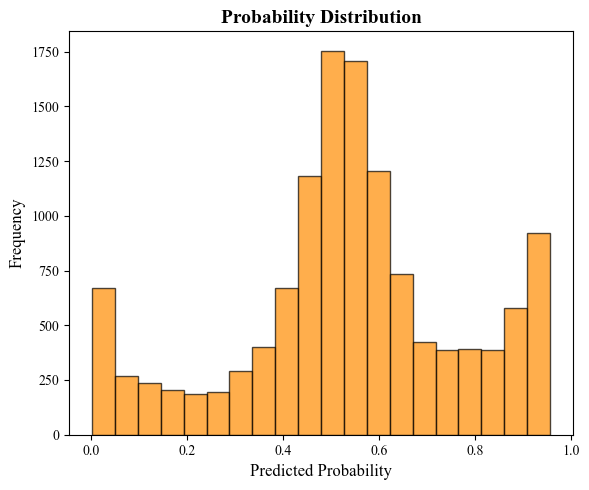

Calculating metrics for thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/miniconda3/envs/inf554/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/inf554/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/inf554/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/i

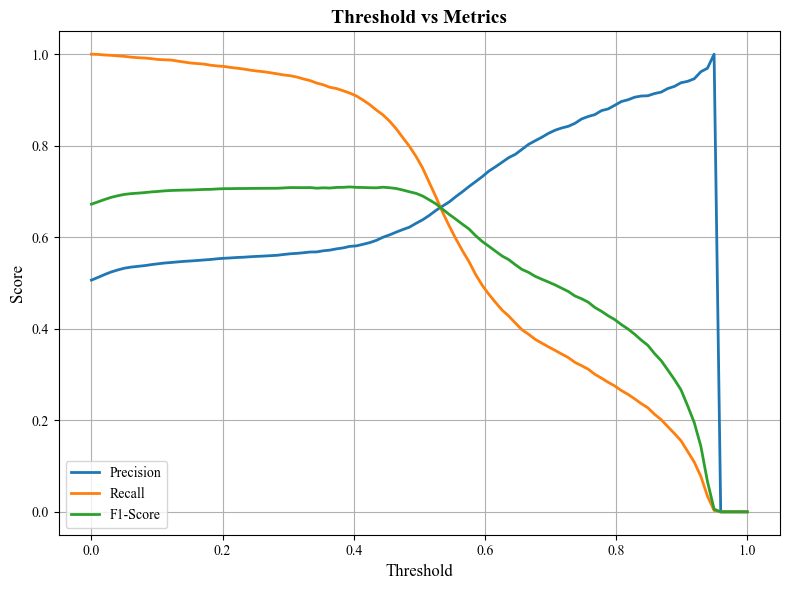

In [10]:
if not RUN_SCRIPT:
    import run_BERT_adjusted as bert_model

    args = {
        'do_eval': True,
        'scan': 'horizontal',
        'fact': 'first',
        'load_dir': 'outputs_fact-first_horizontal_snapshot/save_step_12500',
        'eval_batch_size': 16,
        'do_train': False,
        'threshold': 0.5,
        # Add or override other parameters as needed
    }
    bert_results = bert_model.run_bert_experiment(args)

    if bert_results is not None:
        print("Evaluation results:", bert_results['eval_results'])
        bert_all_labels = bert_results['labels']
        bert_all_probs = bert_results['probs']  # For binary classification
        bert_preds = bert_results['preds']
    
    # PLOTTING
    # Convert probabilities to binary predictions
    bert_pred_labels = [1 if p > args['threshold'] else 0 for p in bert_all_probs]

    save_path = os.path.join(this_dir, 'plots', 'bert_table')
    plot_confusion_matrix(bert_all_labels, bert_pred_labels, title="Confusion Matrix", save_path=os.path.join(save_path, "confusion_matrix.pdf"))
    plot_roc_curve(bert_all_labels, bert_all_probs, title="ROC Curve", save_path=os.path.join(save_path, "roc_curve.pdf"))
    plot_precision_recall_curve(bert_all_labels, bert_all_probs, title="Precision-Recall Curve", save_path=os.path.join(save_path, "precision_recall_curve.pdf"))
    plot_probability_distribution(bert_all_probs, title="Probability Distribution", save_path=os.path.join(save_path, "probability_distribution.pdf"))
    plot_threshold_metrics(bert_all_labels, bert_all_probs, title="Threshold vs Metrics", save_path=os.path.join(save_path, "threshold_metrics.pdf"))

## TAPEX-model

https://github.com/huggingface/transformers/tree/main/examples/research_projects/tapex

In [11]:
%cd ~/Desktop/GitHubProjects/table-fact-checking/TAPEX/

/Users/luka512/Desktop/GitHubProjects/table-fact-checking/TAPEX


In [12]:
if RUN_SCRIPT:
  # Setting environment variable
  os.environ["EXP_NAME"] = "tabfact_tapex_base_eval"

  # Running the command
  !python run_tabfact_with_tapex.py \
    --do_eval \
    --model_name_or_path microsoft/tapex-base-finetuned-tabfact \
    --output_dir $EXP_NAME \
    --per_device_eval_batch_size 12 \
    --eval_accumulation_steps 6

## PASTA

https://github.com/ruc-datalab/PASTA?tab=readme-ov-file

In [5]:
%cd ~/Desktop/GitHubProjects/table-fact-checking/PASTA/

/Users/luka512/Desktop/GitHubProjects/table-fact-checking/PASTA


In [44]:
if RUN_SCRIPT:
    !python src/run_finetune.py src/scripts/train_tabfact.json

/Users/luka512/Desktop/GitHubProjects/table-fact-checking/PASTA utils/dataset.py
/Users/luka512/Desktop/GitHubProjects/table-fact-checking/PASTA
DataArguments(tokenizer_path='/Users/luka512/Desktop/GitHubProjects/table-fact-checking/PASTA/pretrained_models/pasta', cache_file='/Users/luka512/Desktop/GitHubProjects/table-fact-checking/PASTA/data_cache/tabfact', dataset_path='/Users/luka512/Desktop/GitHubProjects/table-fact-checking/original_repo', dataset_name='tabfact')
loading data manager /Users/luka512/Desktop/GitHubProjects/table-fact-checking/PASTA/pretrained_models/pasta
/opt/miniconda3/envs/inf554/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these un

### Compare multiple models

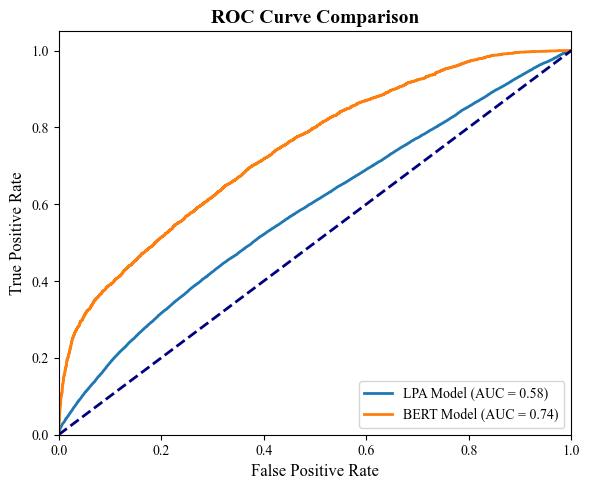

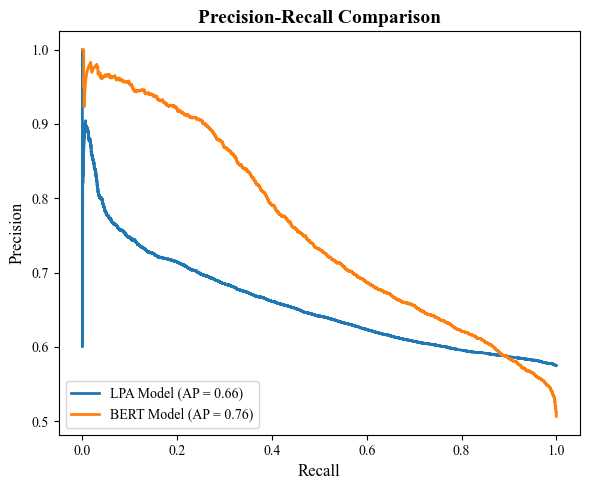

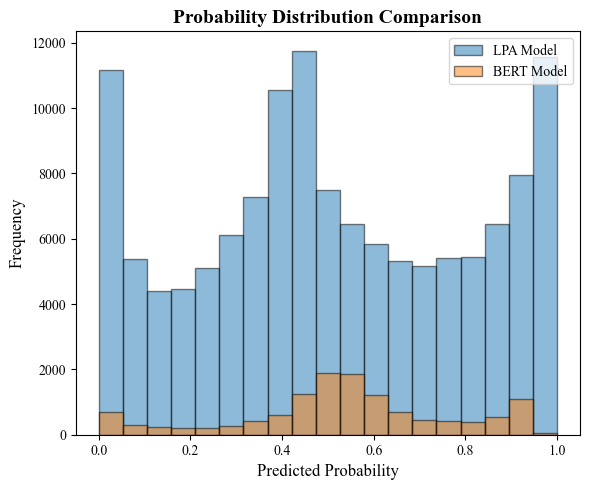

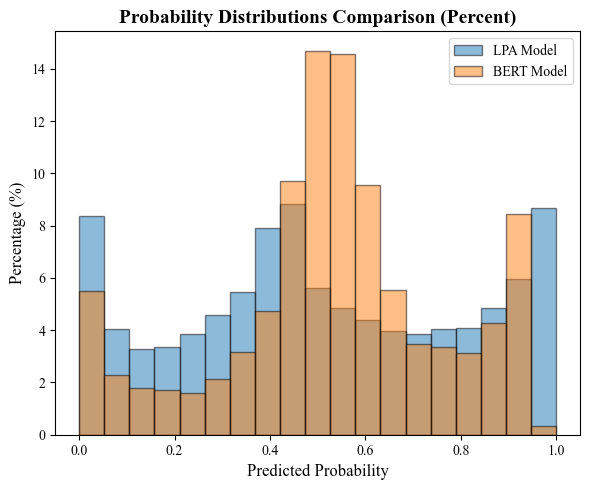

/opt/miniconda3/envs/inf554/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/inf554/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/inf554/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/i

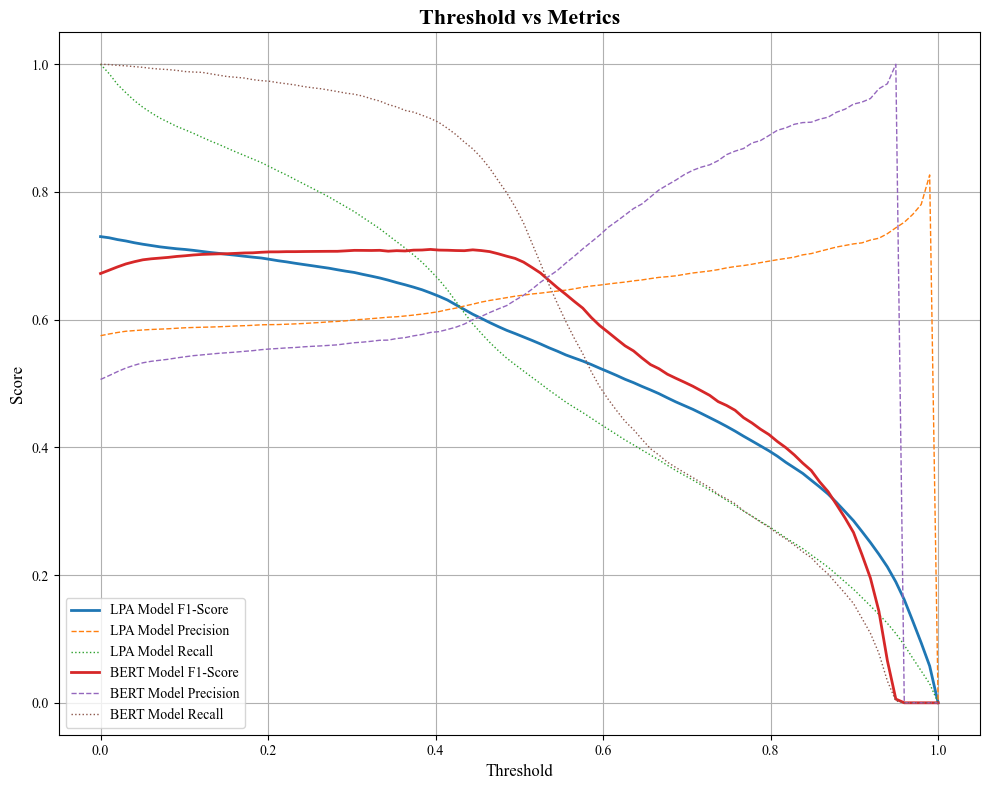

In [13]:
save_path = os.path.join(this_dir, 'plots')

# For ROC:
models_data_roc = [
    {"name": "LPA Model", "labels": lpa_all_labels, "probs": lpa_all_probs},
    {"name": "BERT Model", "labels": bert_all_labels, "probs": bert_all_probs}
]
plot_multi_roc_curves(models_data_roc, title="ROC Curve Comparison", save_path=os.path.join(save_path, "roc_curve_comparison.pdf"))

# For PR:
models_data_pr = [
    {"name": "LPA Model", "labels": lpa_all_labels, "probs": lpa_all_probs},
    {"name": "BERT Model", "labels": bert_all_labels, "probs": bert_all_probs}
]
plot_multi_pr_curves(models_data_pr, title="Precision-Recall Comparison", save_path=os.path.join(save_path, "precision_recall_comparison.pdf"))

# For probability distribution (overlay):
models_data_dist = [
    {"name": "LPA Model", "probs": lpa_all_probs},
    {"name": "BERT Model", "probs": bert_all_probs}
]
plot_multi_probability_distributions(models_data_dist, title="Probability Distribution Comparison", save_path=os.path.join(save_path, "probability_distribution_comparison.pdf"))
plot_multi_probability_distributions_percent(models_data_dist, title="Probability Distributions Comparison (Percent)", save_path=os.path.join(save_path, "probability_distribution_comparison_percent.pdf"))

# For threshold metrics:
models_data_thr = [
    {"name": "LPA Model", "labels": lpa_all_labels, "probs": lpa_all_probs},
    {"name": "BERT Model", "labels": bert_all_labels, "probs": bert_all_probs}
]
plot_multi_threshold_metrics(models_data_thr, title="Threshold vs Metrics", save_path=os.path.join(save_path, "threshold_metrics_comparison.pdf"))